# Maths of AI - project notes


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amackay/MoAI_project/blob/master/MyCoordinateNetworkProject.ipynb)

This notebook contains most of the code that I (Alex Mackay) wrote while working on the project for the subject Mathematics of AI, in 2022 semester 1. It includes my competition entry ("EntryNet"), as well as other models I tried but didn't submit.

For context, the project spec can be found [here](https://github.com/AdelaideUniversityMathSciences/MathsForAI/blob/5971441684cb6a019fdea47312880b86d4f65b2c/Code/Project/CoordinateNetworkProject.ipynb), and a few more details can be found in Lachlan's original draft [here](https://github.com/lemacdonald/CoordinateNetworksExercise/blob/61f34c1d8e395fd1617714b84c7dae20c0abee16/CoordinateNetworkExercise.ipynb).

The code in this notebook was written mainly to aid my own productivity - so, no guarantees on code quality or readability.


## Imports


In [1]:
# Original imports from spec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
device = "cuda:0"  # ??

# Additional imports
import urllib.request
from collections import namedtuple
import torchvision
import torchvision.transforms.functional as vF
import torchvision.io as io
import torchvision.utils as utils
from os.path import exists


## Image handling


In [2]:

# Displays a picture, or a row of pictures.
def show_all(pics):
  if not isinstance(pics, list):
    pics = [pics]
  fig, axs = plt.subplots(
      ncols=len(pics),
      squeeze=False,
      figsize=(20,20),
      gridspec_kw={'wspace': 0.0})
  for i, pic in enumerate(pics):
    if isinstance(pic, Data):
      pic = pic.total
    if pic.colours.shape[0] != pic.width * pic.height:
      raise Exception("Can't show this pic")
    img = pic.colours.reshape(pic.width, pic.height, 3).permute(2,0,1)
    img = img.detach()
    img = vF.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [3]:

# A set of (point, colour) pairs.
class Pic(namedtuple('Pic', ['width', 'height', 'points', 'colours'])):
  def embedded(self, embed):
    return self._replace(points=embed(self.points))
  
  def show(self):
    show_all([self])


In [4]:

# Data derived from an image, formatted as Pics, partitioned into:
# - total: the whole image
# - train: the even pixels
# - test: the odd pixels
# - before: the train pixels, with the gaps filled by grey
class Data(namedtuple('Data', ['total', 'train', 'test', 'before'])):
  def embedded(self, embed):
    return self._replace(
        total=self.total.embedded(embed),
        train=self.train.embedded(embed),
        test=self.test.embedded(embed),)
  
  def show(self):
    show_all([self])
  
  @classmethod
  def new(cls, pil_img):
    if isinstance(pil_img, str):
      pil_img = Image.open(pil_img)
    img = np.array(pil_img)[:,:,:3]
    w = img.shape[0]
    h = img.shape[1]

    x = torch.linspace(0, (w-1)/w, w)
    y = torch.linspace(0, (h-1)/h, h)
    points = torch.stack(torch.meshgrid(x,y)).permute(1,2,0)
    x += 0.5/w
    y += 0.5/h
    fixedpoints = torch.stack(torch.meshgrid(x,y)).permute(1,2,0)
    colours = torch.as_tensor(img, dtype=torch.float32)/256.0
    
    total = Pic(w, h, fixedpoints.flatten(0,1), colours.flatten(0,1))

    train_indices = ( (w*points[:,:,0] + h*points[:,:,1])%2 == 0 )
    train = Pic(
      w, h,
      points=fixedpoints[train_indices],
      colours=colours[train_indices],)
    
    test_indices = ( (w*points[:,:,0] + h*points[:,:,1])%2 == 1 )
    test = Pic(
      w, h,
      points=fixedpoints[test_indices],
      colours=colours[test_indices],)
    
    beforecolours = torch.tensor(colours)
    beforecolours[test_indices] = 0.5
    before = Pic(
        w, h,
        points=fixedpoints.flatten(0,1),
        colours=beforecolours.flatten(0,1))
    
    return Data(total=total, train=train, test=test, before=before)



## Sample image downloads


In [5]:

def cifar10():
  return torchvision.datasets.CIFAR10(
      root='../data', train=True, download=True)

def bird():
  return Data.new(cifar10()[54][0])

def cat():
  return Data.new(cifar10()[9][0])

def deer():
  return Data.new(cifar10()[28][0])

def dog():
  return Data.new(cifar10()[40][0])

def frog():
  return Data.new(cifar10()[25][0])

def horse():
  return Data.new(cifar10()[43][0])

def peppers():
  fname = "peppersddown.png"
  if not exists(fname):
    urllib.request.urlretrieve(
        "https://github.com/AdelaideUniversityMathSciences/MathsForAI/raw/main/Code/Project/peppersddown.png",
        fname)
  return Data.new(fname)


## Training and stats


In [6]:

# Stores a series of points for plotting
class Series(object):
  def __init__(self, label):
    self.label = label
    self.x = []
    self.y = []

  def record(self, loss):
    self.y.append(loss.item())
    if len(self.x) == 0:
      self.x.append(0)
    else:
      self.x.append(self.x[-1]+1)


In [7]:

# Plots one or more series
def plot(*args):
  for series in args:
    print(series.label + " final value: ", series.y[-1])
    plt.plot(series.x, series.y, label=series.label)
  plt.legend(loc="upper right")
  plt.yscale('log')
  # plt.ylim(ymin=0)
  plt.xlabel("epoch")
  plt.ylabel("MSE loss")
  plt.show()


In [22]:

# Stores a neural net class along with hyperparameters for training it
Config = namedtuple('Config', ['name', 'netclass', 'epochs', 'lr', 'weight_decay', 'netargs'])


# A net trained on a particular image Data, with Config providing parameters.
class Model(object):
  @classmethod
  def paramcount(cls, config, imgdata):
    net = config.netclass(
        imgdata.total.width, 
        imgdata.total.height, 
        **config.netargs,)
    net_parameters = filter(lambda p: p.requires_grad, net.parameters())
    count = sum([np.prod(p.size()) for p in net_parameters])
    return count

  def __init__(self, config, imgdata, setseed=False, cheat=False):
    if cheat:
      # Train on the whole image
      imgdata = imgdata._replace(train=imgdata.total)
    self.data = imgdata

    if setseed:
      torch.manual_seed(0)
      np.random.seed(seed)

    self.net = config.netclass(
        self.data.total.width, 
        self.data.total.height, 
        **config.netargs,)
    emb = self.data.embedded(self.net.embed)

    self.loss_func = nn.MSELoss()
    optimizer = optim.Adam(
        self.net.parameters(), 
        lr=config.lr, 
        weight_decay=config.weight_decay,)

    self.trainloss = Series(config.name+" train")
    self.testloss = Series(config.name+" test")

    for i in tqdm(range(config.epochs)):
      with torch.no_grad():
        self.trainloss.record(self.loss(emb.train))
        self.testloss.record(self.loss(emb.test))
      optimizer.zero_grad()
      self.loss(emb.train).backward()
      optimizer.step()
    
    with torch.no_grad():
      self.trainloss.record(self.loss(emb.train))
      self.testloss.record(self.loss(emb.test))
  
  def loss(self, pic):
    return self.loss_func(self.net(pic.points), pic.colours)

  def make_pic(self, w=None, h=None):
    iw = self.data.total.width
    ih = self.data.total.height
    if w is None and h is None:
      w, h = iw, ih
    elif h is None:
      h = round(ih * w/iw)
    elif w is None:
      w = round(iw * h/ih)
    
    x = torch.linspace(0, (w-1)/w, w) + 0.5/w
    y = torch.linspace(0, (h-1)/h, h) + 0.5/h
    points = torch.stack(torch.meshgrid(x,y)).permute(1,2,0).flatten(0,1)
    
    with torch.no_grad():
      colours = self.net(self.net.embed(points))

    return Pic(w, h, points, colours)

  def contrast(self):
    show_all([
      self.data.before,
      self.make_pic(w=512),
      self.make_pic(),
      self.data.total,
    ])


In [9]:

# Class for comparing several models
class Comparison(object):
  def __init__(self):
    self.x = []
    self.y = []
    self.series = []
  
  def add(self, x, model):
    self.x.append(x)
    self.y.append(model.testloss.y[-1])
    self.series.append(model.testloss)
  
  def rm(self, i):
    del self.x[i]
    del self.y[i]
    del self.series[i]

  def plot_epochs(self, xs=None):
    if xs is None:
      xs = self.x
    xsub = []
    ysub = []
    ssub = []
    for i in range(len(self.x)):
      if self.x[i] not in xs:
        continue
      ssub.append(self.series[i])
    plot(*ssub)

  def plot_n(self, log=False):
    plt.scatter(self.x, self.y)
    plt.yscale('log')
    if log:
      plt.xscale('log')
    # plt.ylim(ymin=0)
    plt.xlabel("n")
    plt.ylabel("MSE loss")
    plt.show()


## All the nets


In [10]:

# A basic net, with no embedding.
class BasicNet(nn.Module):
  def __init__(self, w, h, layerwidth):
    super(BasicNet, self).__init__()
    self.fc1 = nn.Linear(2, layerwidth)
    self.fc2 = nn.Linear(layerwidth, layerwidth)
    self.fc3 = nn.Linear(layerwidth, layerwidth)
    self.fc4 = nn.Linear(layerwidth, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x
  
  def embed(self, points):
    return points

basic = Config(
    name='basic',
    netclass=BasicNet,
    epochs=1000,
    lr=0.002,
    weight_decay=0,
    netargs={
        'layerwidth':300,
    },)


# The first example given in the spec
class Example1Net(BasicNet):
  def __init__(self, w, h):
    super(Example1Net, self).__init__(w, h, layerwidth=100)

example1 = Config(
    name='example1',
    netclass=Example1Net,
    epochs=1000,
    lr=1e-3,
    weight_decay=1e-8,
    netargs={
    },)


In [11]:

# Embedding using sin/cos, optionally with multiple frequencies.
class SincosNet(nn.Module):
  def __init__(self, w, h, mults, layerwidth):
    super(SincosNet, self).__init__()
    self.mults = mults
    self.fc1 = nn.Linear(4*mults, layerwidth)
    self.fc2 = nn.Linear(layerwidth, layerwidth)
    self.fc3 = nn.Linear(layerwidth, layerwidth)
    self.fc4 = nn.Linear(layerwidth, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x
  
  def embed(self, x):
    emb = torch.zeros((x.shape[0],4*self.mults))
    for i in range(self.mults):
      m = 2**i
      emb[:,4*i+0] = torch.sin(m*np.pi*x[:,0])
      emb[:,4*i+1] = torch.cos(m*np.pi*x[:,0])
      emb[:,4*i+2] = torch.sin(m*np.pi*x[:,1])
      emb[:,4*i+3] = torch.cos(m*np.pi*x[:,1])
    return emb

sincos = Config(
    name='sincos',
    netclass=SincosNet,
    epochs=1000,
    lr=0.005,
    weight_decay=0,
    netargs={
        'mults':3,
        'layerwidth':200,
    },)


# The second example given in the spec
class Example2Net(SincosNet):
  def __init__(self, w, h):
    super(Example2Net, self).__init__(w, h, mults=1, layerwidth=100)

example2 = Config(
    name='example2',
    netclass=Example2Net,
    epochs=1000,
    lr=1e-3,
    weight_decay=1e-8,
    netargs={
    },)


In [12]:

# Emulate bilinear interpolation
class BiliNet(nn.Module):
  def __init__(self, w, h):
    super(BiliNet, self).__init__()

    self.dims = (w,h)
    self.refpoints = []
    for ix in range(w):
      cx = ix + 0.5
      for iy in range(h):
        if (ix + iy)%2 == 1:
          continue
        cy = iy + 0.5
        self.refpoints.append((cx,cy))

    self.fc1 = nn.Linear(len(self.refpoints), 3)

  def forward(self, x):
    x = F.hardsigmoid(self.fc1(x))
    return x - 0.5/256.0
  
  def embed(self, points):
    w,h = self.dims
    px = points[:,0] * w
    py = points[:,1] * h
    pz = (px + py)/2
    pw = (px - py)/2

    emb = torch.zeros((points.shape[0], len(self.refpoints)))
    for i, ref in enumerate(self.refpoints):
      cx, cy = ref
      cz = (cx + cy)/2
      cw = (cx - cy)/2
      dz = torch.abs(pz - cz)
      dw = torch.abs(pw - cw)
      distz = torch.clamp(1 - dz, min=0)
      distw = torch.clamp(1 - dw, min=0)
      dist = distz*distw
      emb[:,i] = dist
    return emb

bili = Config(
    name='bili',
    netclass=BiliNet,
    epochs=200,
    lr=0.2,
    weight_decay=0,
    netargs={
    },)


In [13]:

# Diagonal axes at various angles
# Unsurprisingly, performs no better than BasicNet
class DiagNet(nn.Module):
  def __init__(self, w, h, multiplier, layerwidth):
    super(DiagNet, self).__init__()
    self.mult = multiplier
    self.fc1 = nn.Linear(2*multiplier, layerwidth)
    self.fc2 = nn.Linear(layerwidth, layerwidth)
    self.fc3 = nn.Linear(layerwidth, layerwidth)
    self.fc4 = nn.Linear(layerwidth, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x - 0.5/256.0
  
  def embed(self, points):
    xs = 2*points[:,0] - 1
    ys = 2*points[:,1] - 1

    its = 2*self.mult
    emb = torch.zeros((points.shape[0], its))
    for i in range(its):
      rot = np.pi * i/its
      emb[:, i] = xs*np.cos(rot) + ys*np.sin(rot)
    return emb

diag = Config(
    name='diag',
    netclass=DiagNet,
    epochs=1000,
    lr=0.002,
    weight_decay=0,
    netargs={
        'multiplier':0,
        'layerwidth':300,
    },)


In [14]:

# Distances from a grid of points, raised to a power.
# Known bug: positive powers don't seem to work.
class PowdistNet(nn.Module):
  def __init__(self, w, h, s, layerwidth, power):
    super(PowdistNet, self).__init__()

    self.power = power
    self.dims = (w,h)
    self.s = s

    self.fc1 = nn.Linear(s*s, layerwidth)
    self.fc2 = nn.Linear(layerwidth, layerwidth)
    self.fc3 = nn.Linear(layerwidth, layerwidth)
    self.fc4 = nn.Linear(layerwidth, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x - 0.5/256.0
  
  def embed(self, points):
    w,h = self.dims
    wh = (w+h)/2
    s = self.s
    xs = points[:,0] * w
    ys = points[:,1] * h
    emb = torch.zeros((points.shape[0], s*s))
    for ix in range(s):
      cx = w*(ix+0.5)/s
      dx = xs - cx
      sqdx = dx*dx
      for iy in range(s):
        cy = h*(iy+0.5)/s
        dy = ys - cy
        sqdy = dy*dy
        d = torch.sqrt(sqdx + sqdy) + 1e-8
        emb[:,ix*s + iy] = torch.pow(d, self.power)
    return emb


powdist = Config(
    name='powdist',
    netclass=PowdistNet,
    epochs=1000,
    lr=0.01,
    weight_decay=0,
    netargs={
        's':15,
        'layerwidth': 150,
        'power': -1,
    },)


In [15]:

# Grid of cones
class ConeNet(nn.Module):
  def __init__(self, w, h, s, layerwidth, limfactor):
    super(ConeNet, self).__init__()

    self.limfactor = limfactor
    self.dims = (w,h)
    self.s = s

    self.fc1 = nn.Linear(s*s, layerwidth)
    self.fc2 = nn.Linear(layerwidth, layerwidth)
    self.fc3 = nn.Linear(layerwidth, layerwidth)
    self.fc4 = nn.Linear(layerwidth, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x - 0.5/256.0
  
  def embed(self, points):
    w,h = self.dims
    wh = (w+h)/2
    s = self.s
    lim = self.limfactor*wh/s
    xs = points[:,0] * w
    ys = points[:,1] * h
    emb = torch.zeros((points.shape[0], s*s))
    for ix in range(s):
      cx = w*(ix+0.5)/s
      dx = xs - cx
      sqdx = dx*dx
      for iy in range(s):
        cy = h*(iy+0.5)/s
        dy = ys - cy
        sqdy = dy*dy
        d = torch.sqrt(sqdx + sqdy)
        d2 = torch.clamp_min(lim - d, 0) / lim
        emb[:,ix*s + iy] = d2
    return emb

cone = Config(
    name='cone',
    netclass=ConeNet,
    epochs=1000,
    lr=0.01,
    weight_decay=0,
    netargs={
        's':15,
        'layerwidth': 150,
        'limfactor': 2.75,
    },)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


79653

In [16]:

# An attempt to make ConeNet scale better by using convolution.
# Couldn't get it working well.
class ConveNet(nn.Module):
  def __init__(self, w, h, s, layerwidth, limfactor):
    super(ConveNet, self).__init__()

    self.limfactor = limfactor
    self.dims = (w,h)
    self.s = s

    self.conv1 = nn.Conv2d(1, 1, kernel_size=5, padding='same')
    self.fc2 = nn.Linear(s*s, layerwidth)
    self.fc3 = nn.Linear(layerwidth, layerwidth)
    self.last = nn.Linear(layerwidth, 3)

  def forward(self, x):
    x = F.relu(self.conv1(x))

    x = torch.flatten(x, start_dim=1)

    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.last(x))
    return x - 0.5/256.0
  
  def embed(self, points):
    w,h = self.dims
    wh = (w+h)/2
    s = self.s
    lim = self.limfactor*wh/s
    xs = points[:,0] * w
    ys = points[:,1] * h
    emb = torch.zeros((points.shape[0], s, s))
    for ix in range(s):
      cx = w*(ix+0.5)/s
      dx = xs - cx
      sqdx = dx*dx
      for iy in range(s):
        cy = h*(iy+0.5)/s
        dy = ys - cy
        sqdy = dy*dy
        d = torch.sqrt(sqdx + sqdy)
        d2 = torch.clamp_min(lim - d, 0) / lim
        emb[:,ix,iy] = d2
    return torch.unsqueeze(emb, 1)

conve = Config(
    name='conve',
    netclass=ConveNet,
    epochs=1000,
    lr=0.01,
    weight_decay=0,
    netargs={
        's':15,
        'layerwidth': 150,
        'limfactor': 2.75,
    },)


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


57029

In [17]:

# Grid of cones, tuned for peppers.
# (My competition entry)
class EntryNet(nn.Module):
  def __init__(self, w, h, s, limfactor):
    super(EntryNet, self).__init__()

    self.limfactor = limfactor
    self.dims = (w,h)
    self.s = s

    self.fc1 = nn.Linear(s*s, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x - 0.5/256.0
  
  def embed(self, points):
    w,h = self.dims
    wh = (w+h)/2
    s = self.s
    lim = self.limfactor*wh/s
    xs = points[:,0] * w
    ys = points[:,1] * h
    emb = torch.zeros((points.shape[0], s*s))
    for ix in range(s):
      cx = w*(ix+0.5)/s
      dx = xs - cx
      sqdx = dx*dx
      for iy in range(s):
        cy = h*(iy+0.5)/s
        dy = ys - cy
        sqdy = dy*dy
        d = torch.sqrt(sqdx + sqdy)
        d2 = torch.clamp_min(lim - d, 0) / lim
        emb[:,ix*s + iy] = d2
    return emb

entry = Config(
    name='entry',
    netclass=EntryNet,
    epochs=1000,
    lr=0.01,
    weight_decay=0,
    netargs={
        's':64,
        'limfactor': 4,
    },)


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


137571

In [26]:
tuned_configs = [example1, example2, basic, sincos, bili, diag, powdist, cone, conve]


## Running and comparing models


In [27]:
the_deer = deer()
the_peppers = peppers()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


100%|██████████| 1000/1000 [00:12<00:00, 79.33it/s]


cone train final value:  8.10015535535058e-06
cone test final value:  0.0014869443839415908


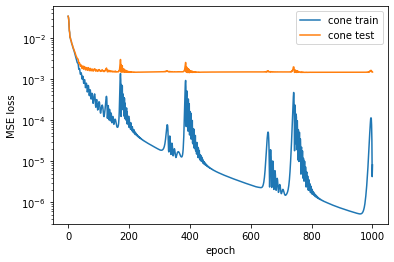

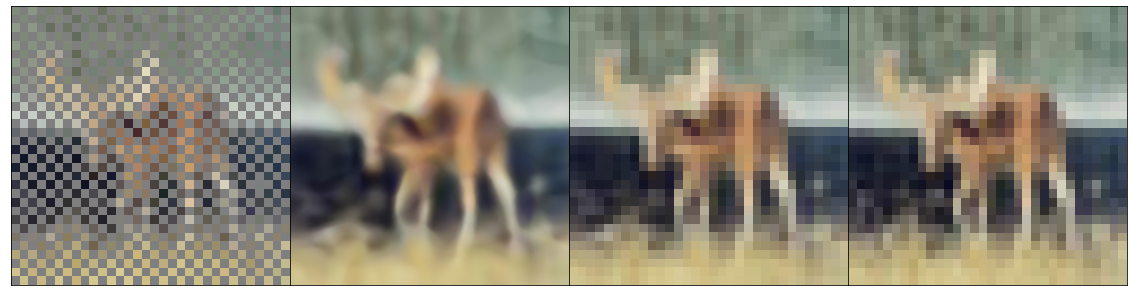

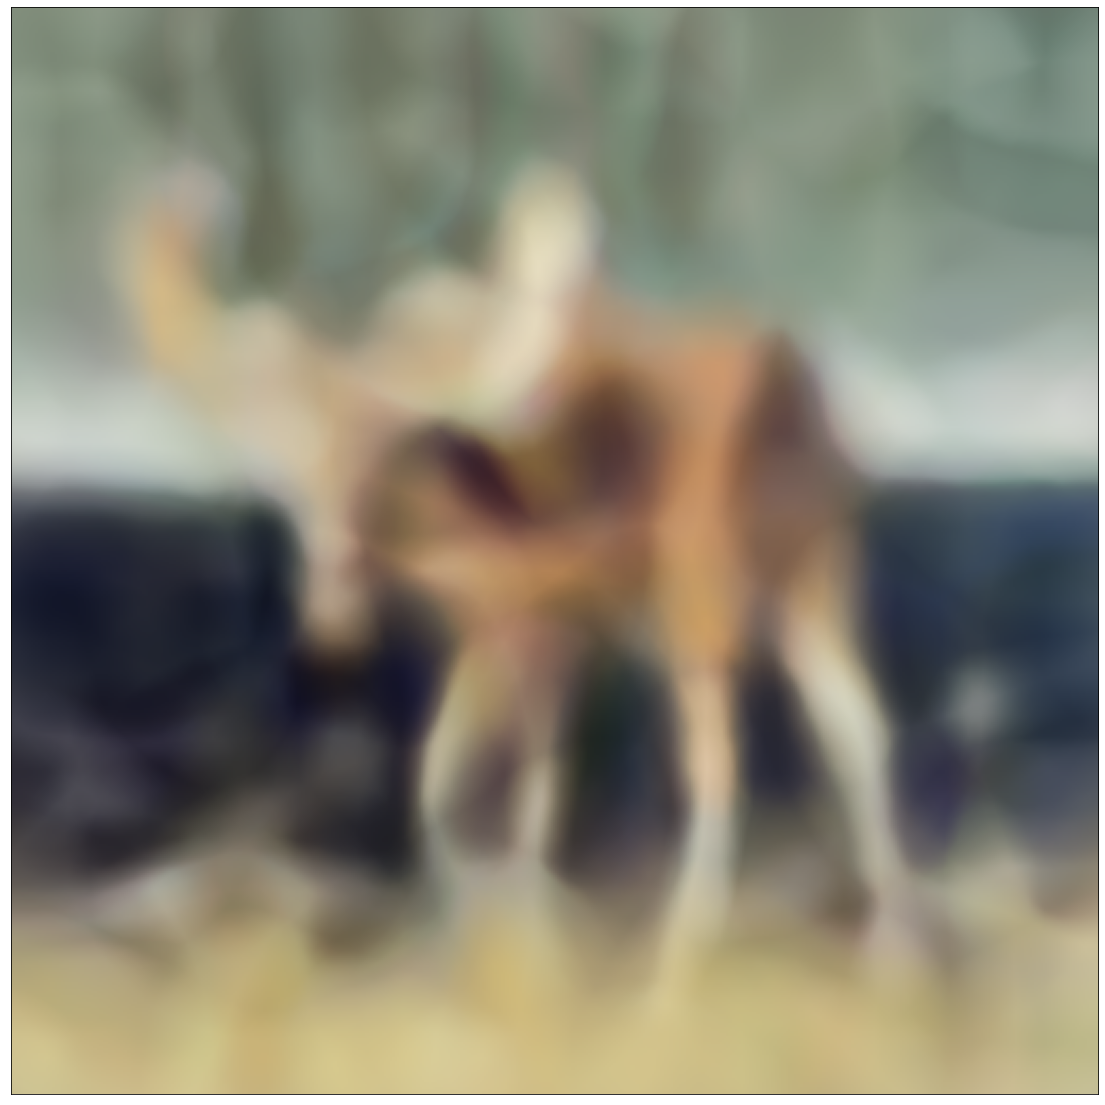

In [28]:
# Train a model and view the results
m = Model(cone, the_deer)
plot(m.trainloss, m.testloss)
m.contrast()
m.make_pic(512).show()


In [29]:
print("How many trainable parameters does each model have?")
for cfg in tuned_configs:
  print(cfg.name + ": " + str(Model.paramcount(cfg, the_deer)))


How many trainable parameters does each model have?
example1: 20803
example2: 21003
basic: 182403
sincos: 83603
bili: 1539
diag: 181803
powdist: 79653
cone: 79653
conve: 57029


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


100%|██████████| 100/100 [00:00<00:00, 797.24it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|██████████| 100/100 [00:02<00:00, 35.52it/s]


example1 test final value:  0.014076248742640018
example2 test final value:  0.008961616083979607
basic test final value:  0.009163990616798401
sincos test final value:  0.0018722680397331715
bili test final value:  0.0031206209678202868
diag test final value:  0.03286242112517357
powdist test final value:  0.005175648722797632
cone test final value:  0.0017195200780406594
conve test final value:  0.0018156584119424224


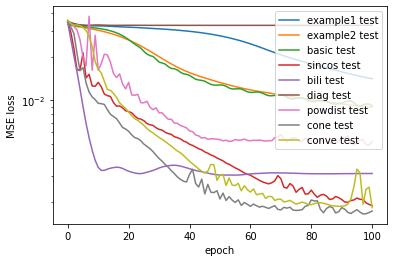

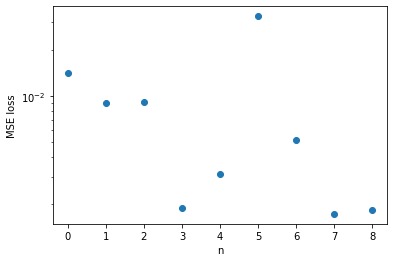

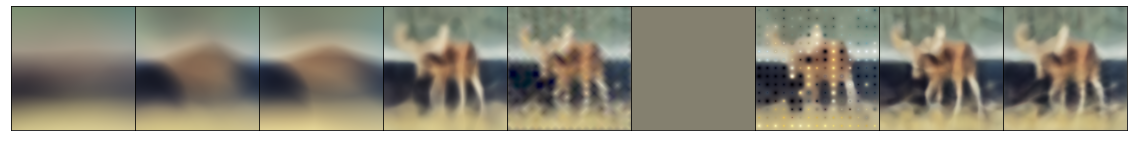

In [30]:

# Compare all configs, with only 100 epochs

comp1 = Comparison() # Init a blank comparison

ns = range(len(tuned_configs))

pics = []
mods = []
for n in ns:
  cfg = tuned_configs[n]._replace(epochs=100)
  mod = Model(cfg, the_deer)
  pics.append(mod.make_pic(512))
  comp1.add(n, mod)

comp1.plot_epochs(ns)
comp1.plot_n()
show_all(pics)


In [45]:

comp2 = Comparison() # Init a blank comparison


100%|██████████| 100/100 [00:00<00:00, 103.13it/s]


cone 0.25 test final value:  0.02699378691613674
cone 0.5 test final value:  0.016291098669171333
cone 0.75 test final value:  0.00743325799703598
cone 1.0 test final value:  0.00274495012126863
cone 2.0 test final value:  0.0017578629776835442
cone 3.0 test final value:  0.0028617307543754578
cone 4.0 test final value:  0.004902040120214224
cone 0.25 test final value:  0.027005156502127647
cone 0.5 test final value:  0.01630243845283985
cone 0.75 test final value:  0.0071329097263514996
cone 1.0 test final value:  0.0029248008504509926
cone 2.0 test final value:  0.002285229740664363
cone 3.0 test final value:  0.0027853853534907103
cone 4.0 test final value:  0.0050491527654230595
cone 0.25 test final value:  0.02700560726225376
cone 0.5 test final value:  0.016248809173703194
cone 0.75 test final value:  0.007134485989809036
cone 1.0 test final value:  0.002822193317115307
cone 2.0 test final value:  0.001949911005795002
cone 3.0 test final value:  0.0031598408240824938
cone 4.0 tes

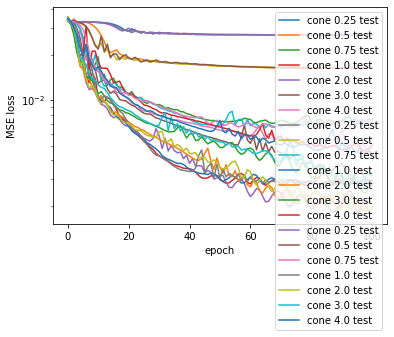

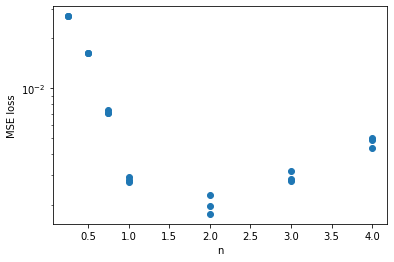

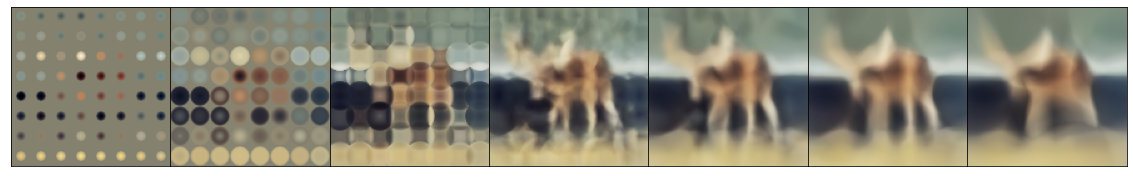

In [48]:
# Compare different radii for cones
# Run again for more data points

xs = [0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0]

pics = []
for x in xs:
  cfg = cone._replace(
    name=cone.name + " " + str(x),
    epochs=100,
    netargs={
      's':8,  # reference point grid size
      'layerwidth': 150,
      'limfactor': x,  # cone radius
    }
  )
  mod = Model(cfg, the_deer)
  pics.append(mod.make_pic(128))
  comp2.add(x, mod)

comp2.plot_epochs()
comp2.plot_n()
show_all(pics)


entry train final value:  0.00022270518820732832
entry test final value:  0.0003246527339797467


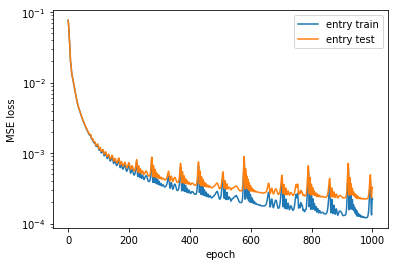

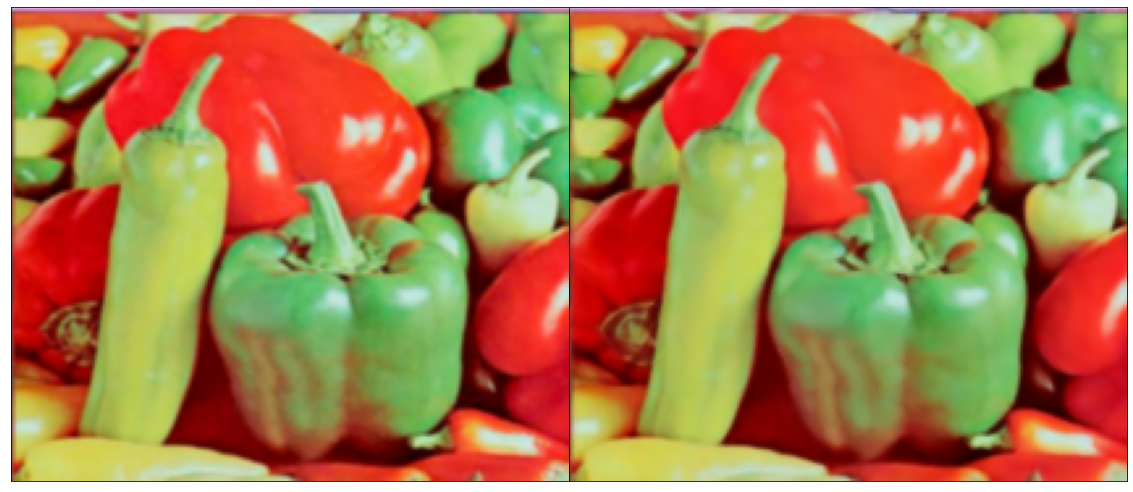

In [51]:

# This is my competition entry, tuned for peppers.
# Takes ~10min to run.

# m = Model(entry, the_peppers)
# plot(m.trainloss, m.testloss)
# show_all([the_peppers, m.make_pic()])
